In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def analyze_vocabulary(datasets):
    # Combining datasets for overall analysis
    all_docs = []
    all_summaries = []

    for df in datasets.values():
        all_docs.extend(df['document'].dropna().tolist())
        all_summaries.extend(df['summary'].dropna().tolist())

    # Sample for efficiency if datasets are large
    sample_size = min(1000, len(all_docs))
    sampled_indices = np.random.choice(len(all_docs), sample_size, replace=False)

    # Get words from sampled documents and summaries
    stop_words = set(stopwords.words('english'))

    doc_words = []
    for i in sampled_indices:
        tokens = word_tokenize(str(all_docs[i]).lower())
        # Filter out stopwords and non-alphabetic tokens
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        doc_words.extend(filtered_tokens)

    summary_words = []
    for i in sampled_indices:
        tokens = word_tokenize(str(all_summaries[i]).lower())
        # Filter out stopwords and non-alphabetic tokens
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        summary_words.extend(filtered_tokens)

    # Count frequencies
    doc_word_freq = Counter(doc_words)
    summary_word_freq = Counter(summary_words)

    # Prepare word clouds
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Document word cloud
    doc_wordcloud = WordCloud(width=800, height=400, background_color='white',
                              max_words=100, colormap='viridis').generate_from_frequencies(doc_word_freq)
    ax1.imshow(doc_wordcloud, interpolation='bilinear')
    ax1.set_title('Common Words in Documents')
    ax1.axis('off')

    # Summary word cloud
    summary_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 max_words=100, colormap='plasma').generate_from_frequencies(summary_word_freq)
    ax2.imshow(summary_wordcloud, interpolation='bilinear')
    ax2.set_title('Common Words in Summaries')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Create bar charts for top words instead of printing
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Top words in documents
    doc_top_words = dict(doc_word_freq.most_common(20))
    ax1.barh(list(reversed(list(doc_top_words.keys()))), list(reversed(list(doc_top_words.values()))), color='skyblue')
    ax1.set_title('Top 20 Words in Documents')
    ax1.set_xlabel('Frequency')

    # Top words in summaries
    summary_top_words = dict(summary_word_freq.most_common(20))
    ax2.barh(list(reversed(list(summary_top_words.keys()))), list(reversed(list(summary_top_words.values()))), color='lightcoral')
    ax2.set_title('Top 20 Words in Summaries')
    ax2.set_xlabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Comparison bar chart of common words in both documents and summaries
    common_words = set(dict(doc_word_freq.most_common(50)).keys()) & set(dict(summary_word_freq.most_common(50)).keys())
    common_words = sorted(common_words, key=lambda w: doc_word_freq[w] + summary_word_freq[w], reverse=True)[:15]

    if common_words:
        fig, ax = plt.subplots(figsize=(15, 8))
        x = np.arange(len(common_words))
        width = 0.35

        doc_values = [doc_word_freq[word] for word in common_words]
        summary_values = [summary_word_freq[word] for word in common_words]

        ax.bar(x - width/2, doc_values, width, label='Documents')
        ax.bar(x + width/2, summary_values, width, label='Summaries')

        ax.set_title('Common Words Comparison: Documents vs Summaries')
        ax.set_xlabel('Words')
        ax.set_ylabel('Frequency')
        ax.set_xticks(x)
        ax.set_xticklabels(common_words, rotation=45, ha='right')
        ax.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
def visualize_length_distributions(datasets):
    all_doc_lengths = []
    all_summary_lengths = []

    # Get lengths from each file
    for name, df in datasets.items():
        doc_lengths = df['document'].apply(lambda x: len(str(x).split()))
        summary_lengths = df['summary'].apply(lambda x: len(str(x).split()))

        all_doc_lengths.extend(doc_lengths.tolist())
        all_summary_lengths.extend(summary_lengths.tolist())

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot document lengths
    sns.histplot(all_doc_lengths, bins=30, kde=True, color="blue", ax=ax1)
    ax1.set_xlabel("Word Count")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Document Length Distribution")

    # Plot summary lengths
    sns.histplot(all_summary_lengths, bins=30, kde=True, color="red", ax=ax2)
    ax2.set_xlabel("Word Count")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Summary Length Distribution")

    plt.tight_layout()
    plt.show()

    # Create a plot comparing both with log scale
    plt.figure(figsize=(12, 6))
    sns.histplot(all_doc_lengths, bins=30, kde=False, label="Documents", color="blue", alpha=0.6)
    sns.histplot(all_summary_lengths, bins=30, kde=False, label="Summaries", color="red", alpha=0.6)
    plt.xlabel("Word Count")
    plt.ylabel("Frequency (log scale)")
    plt.yscale('log')
    plt.legend()
    plt.title("Length Distribution of Documents and Summaries (Log Scale)")
    plt.tight_layout()
    plt.show()



In [ ]:
# Function to check for financial entity recognition
def financial_entity_analysis(datasets):
    patterns = {
        'monetary_values': r'\$\s*\d+(?:\.\d+)?(?:\s*(?:million|billion|thousand|M|B|K))?|\d+(?:\.\d+)?\s*(?:million|billion|thousand|M|B|K)\s*(?:dollars|\$)',
        'percentages': r'\d+(?:\.\d+)?%',
        'dates': r'\b(?:19|20)\d{2}\b|\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2}(?:,\s+(?:19|20)\d{2})?\b|\b\d{1,2}/\d{1,2}/\d{2,4}\b',
        'financial_terms': r'\b(?:revenue|profit|EBITDA|income|expense|margin|dividend|equity|asset|liability|depreciation|amortization|cash flow|liquidity|fiscal)\b'
    }

    # Sample a small subset for efficiency
    combined_df = pd.concat(datasets.values()).sample(min(1000, len(pd.concat(datasets.values()))))

    # Analyze documents and summaries
    entity_counts = {'documents': {}, 'summaries': {}}

    for pattern_name, pattern in patterns.items():
        doc_matches = []
        summary_matches = []

        for doc in combined_df['document']:
            matches = re.findall(pattern, str(doc), re.IGNORECASE)
            doc_matches.append(len(matches))

        for summary in combined_df['summary']:
            matches = re.findall(pattern, str(summary), re.IGNORECASE)
            summary_matches.append(len(matches))

        entity_counts['documents'][pattern_name] = doc_matches
        entity_counts['summaries'][pattern_name] = summary_matches

    # Visualize findings
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, (pattern_name, _) in enumerate(patterns.items()):
        doc_avg = np.mean(entity_counts['documents'][pattern_name])
        summary_avg = np.mean(entity_counts['summaries'][pattern_name])

        # Normalize by average document/summary length
        doc_len = combined_df['document'].apply(lambda x: len(str(x).split())).mean()
        summary_len = combined_df['summary'].apply(lambda x: len(str(x).split())).mean()

        doc_norm = doc_avg / doc_len * 1000  # Per 1000 words
        summary_norm = summary_avg / summary_len * 1000  # Per 1000 words

        ax = axes[i]
        ax.bar(['Documents', 'Summaries'], [doc_norm, summary_norm])
        ax.set_title(f'{pattern_name.replace("_", " ").title()} (per 1000 words)')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [ ]:
# Setting plot details
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Function to load all datasets
def load_datasets(folder_path="findsum_roo_dataset"):
    # Listing all the test dataset files
    files = [
        "test_roo_segment_0_input_2_1000",
        "test_roo_segment_1_input_2_1000"
    ]

    datasets = {}
    for file in files:
        try:
            file_path = os.path.join(folder_path, file + ".csv")
            df = pd.read_csv(file_path)
            datasets[file] = df
            print(f"Loaded {file} with shape: {df.shape}")
        except Exception as e:
            print(f"Error loading {file}: {e}")

    return datasets

# Function to calculate basic statistics for all datasets
def get_basic_stats(datasets):
    stats = {}

    for name, df in datasets.items():
        # Handle potential missing values
        df_clean = df.copy()
        if df_clean['document'].isna().any():
            print(f"Warning: {df_clean['document'].isna().sum()} missing documents in {name}")
            df_clean = df_clean.dropna(subset=['document'])

        if df_clean['summary'].isna().any():
            print(f"Warning: {df_clean['summary'].isna().sum()} missing summaries in {name}")
            df_clean = df_clean.dropna(subset=['summary'])

        # Calculate statistics
        doc_lengths = df_clean['document'].apply(lambda x: len(word_tokenize(str(x))))
        summary_lengths = df_clean['summary'].apply(lambda x: len(word_tokenize(str(x))))

        # Calculate compression ratio (document length / summary length)
        compression_ratios = doc_lengths / summary_lengths

        # Calculate number of sentences
        doc_sentence_counts = df_clean['document'].apply(lambda x: len(sent_tokenize(str(x))))
        summary_sentence_counts = df_clean['summary'].apply(lambda x: len(sent_tokenize(str(x))))

        stats[name] = {
            'count': len(df_clean),
            'doc_length': {
                'mean': doc_lengths.mean(),
                'std': doc_lengths.std(),
                'min': doc_lengths.min(),
                'max': doc_lengths.max(),
                'median': doc_lengths.median(),
            },
            'summary_length': {
                'mean': summary_lengths.mean(),
                'std': summary_lengths.std(),
                'min': summary_lengths.min(),
                'max': summary_lengths.max(),
                'median': summary_lengths.median(),
            },
            'compression_ratio': {
                'mean': compression_ratios.mean(),
                'std': compression_ratios.std(),
                'min': compression_ratios.min(),
                'max': compression_ratios.max(),
                'median': compression_ratios.median(),
            },
            'doc_sentences': {
                'mean': doc_sentence_counts.mean(),
                'std': doc_sentence_counts.std(),
                'min': doc_sentence_counts.min(),
                'max': doc_sentence_counts.max(),
                'median': doc_sentence_counts.median(),
            },
            'summary_sentences': {
                'mean': summary_sentence_counts.mean(),
                'std': summary_sentence_counts.std(),
                'min': summary_sentence_counts.min(),
                'max': summary_sentence_counts.max(),
                'median': summary_sentence_counts.median(),
            }
        }

    return stats



Loading FINDSum ROO datasets...
Loaded test_roo_segment_0_input_2_1000 with shape: (2102, 2)
Loaded test_roo_segment_1_input_2_1000 with shape: (2102, 2)

Basic stats calculations:

===== Dataset Statistics =====

--- test_roo_segment_0_input_2_1000 ---
Number of samples: 2102
Document lengths (words): Mean = 1993.9, Median = 2001.0, Max = 2059.0
Summary lengths (words): Mean = 304.5, Median = 312.0, Max = 370.0
Compression ratio: Mean = 6.6, Median = 6.4
Document sentences: Mean = 55.5, Median = 56.0
Summary sentences: Mean = 7.6, Median = 7.0

--- test_roo_segment_1_input_2_1000 ---
Number of samples: 2102
Document lengths (words): Mean = 1993.8, Median = 2001.0, Max = 2061.0
Summary lengths (words): Mean = 357.5, Median = 353.0, Max = 484.0
Compression ratio: Mean = 5.6, Median = 5.6
Document sentences: Mean = 55.2, Median = 55.0
Summary sentences: Mean = 8.8, Median = 9.0

Length distribution:


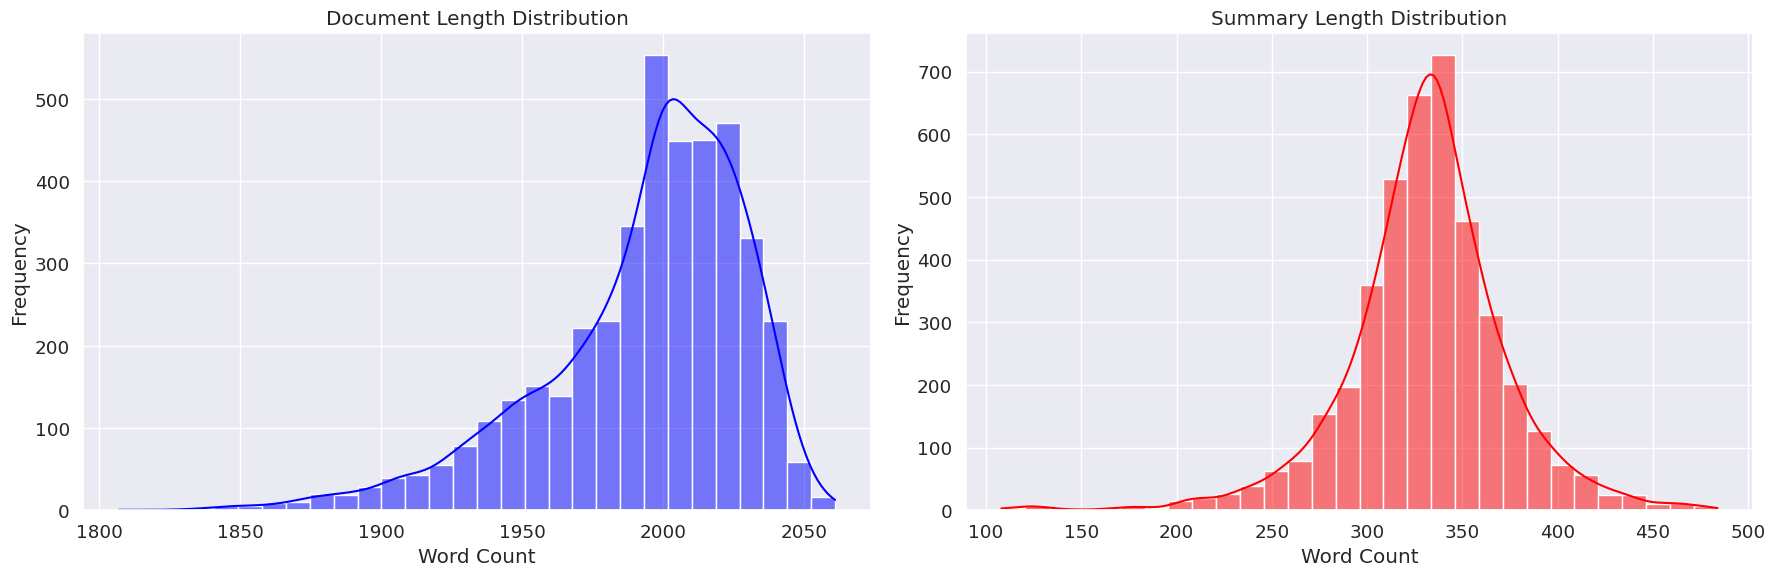

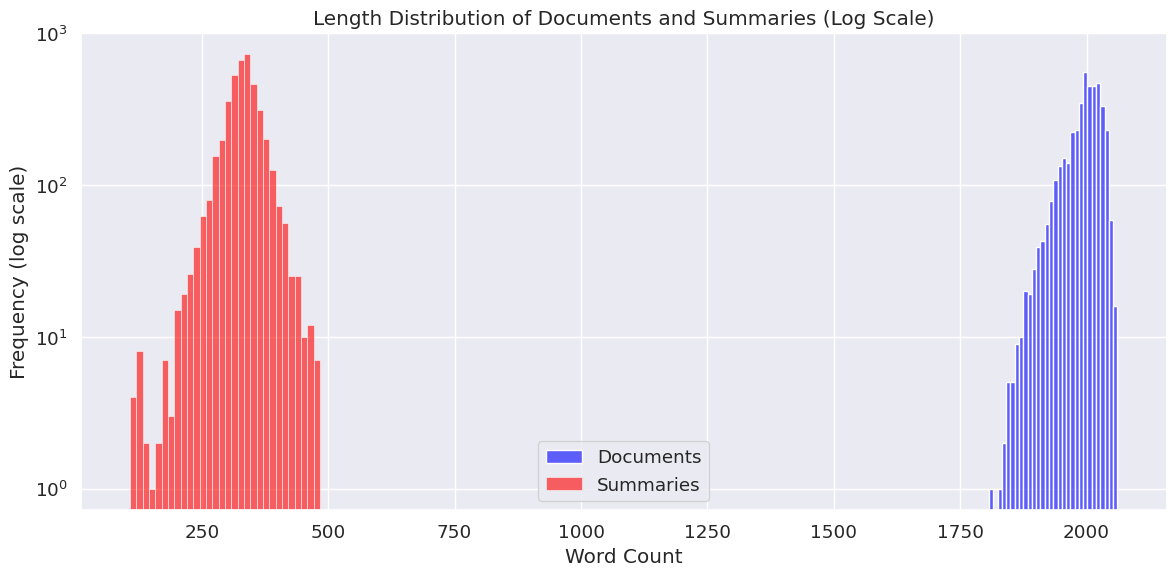


Vocabulary analysis:


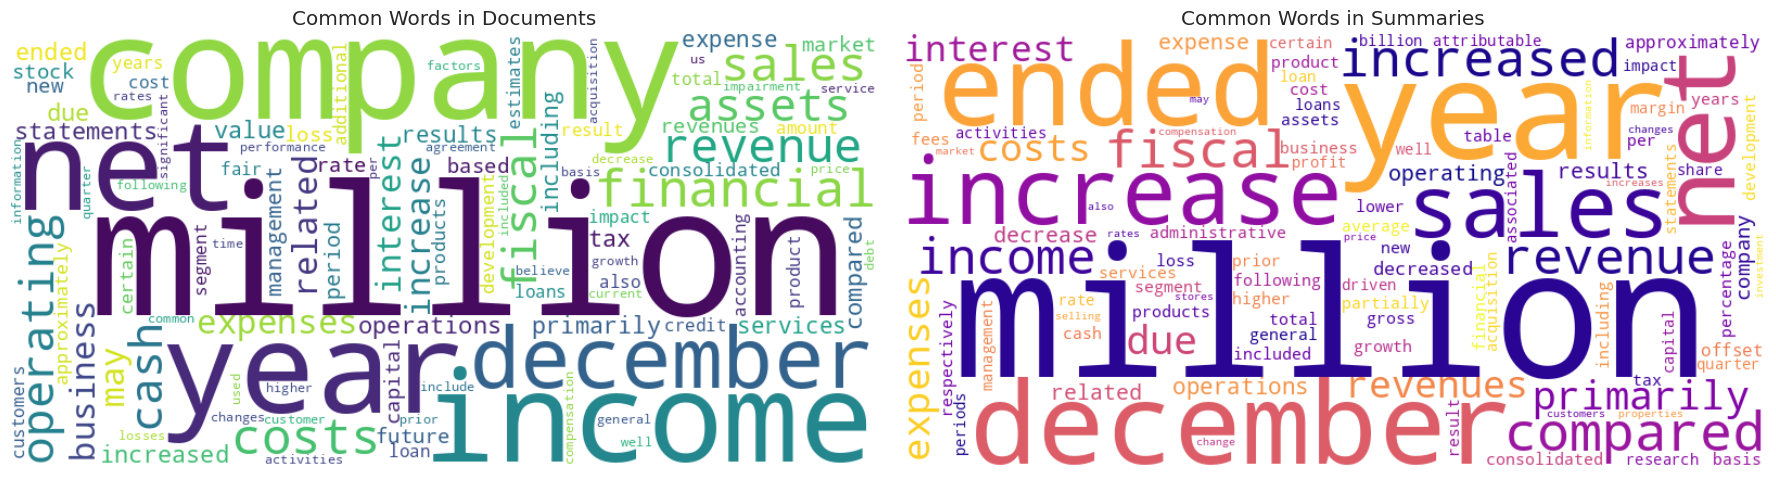

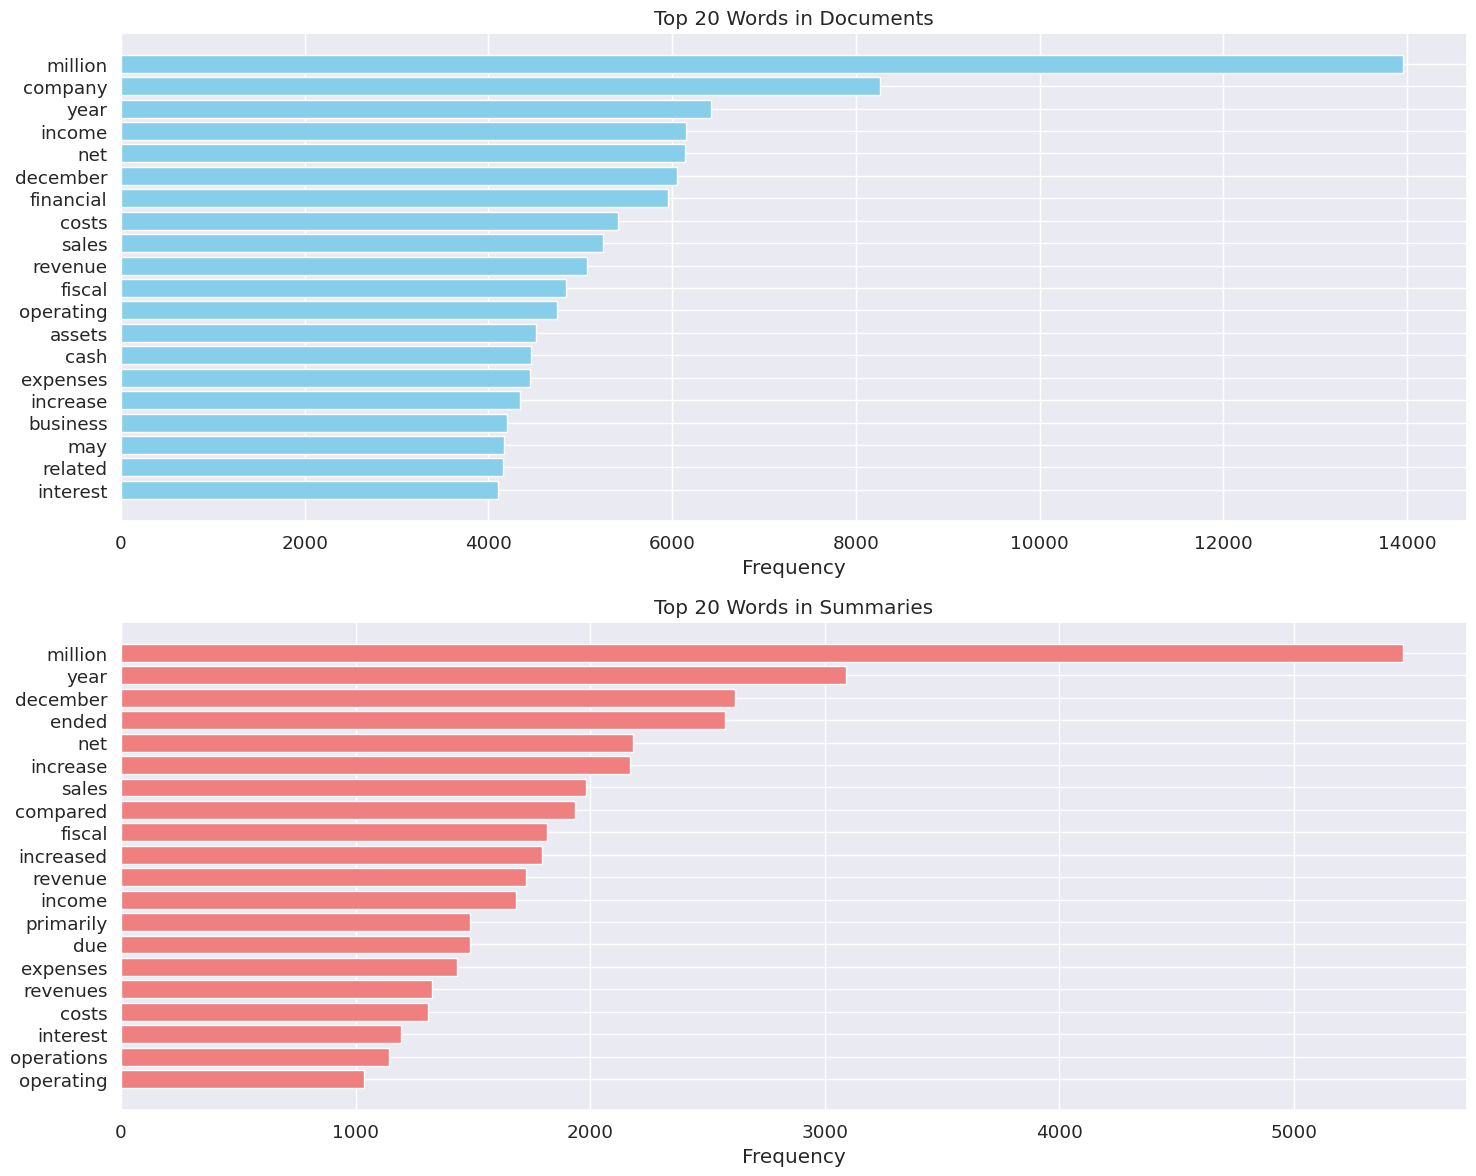

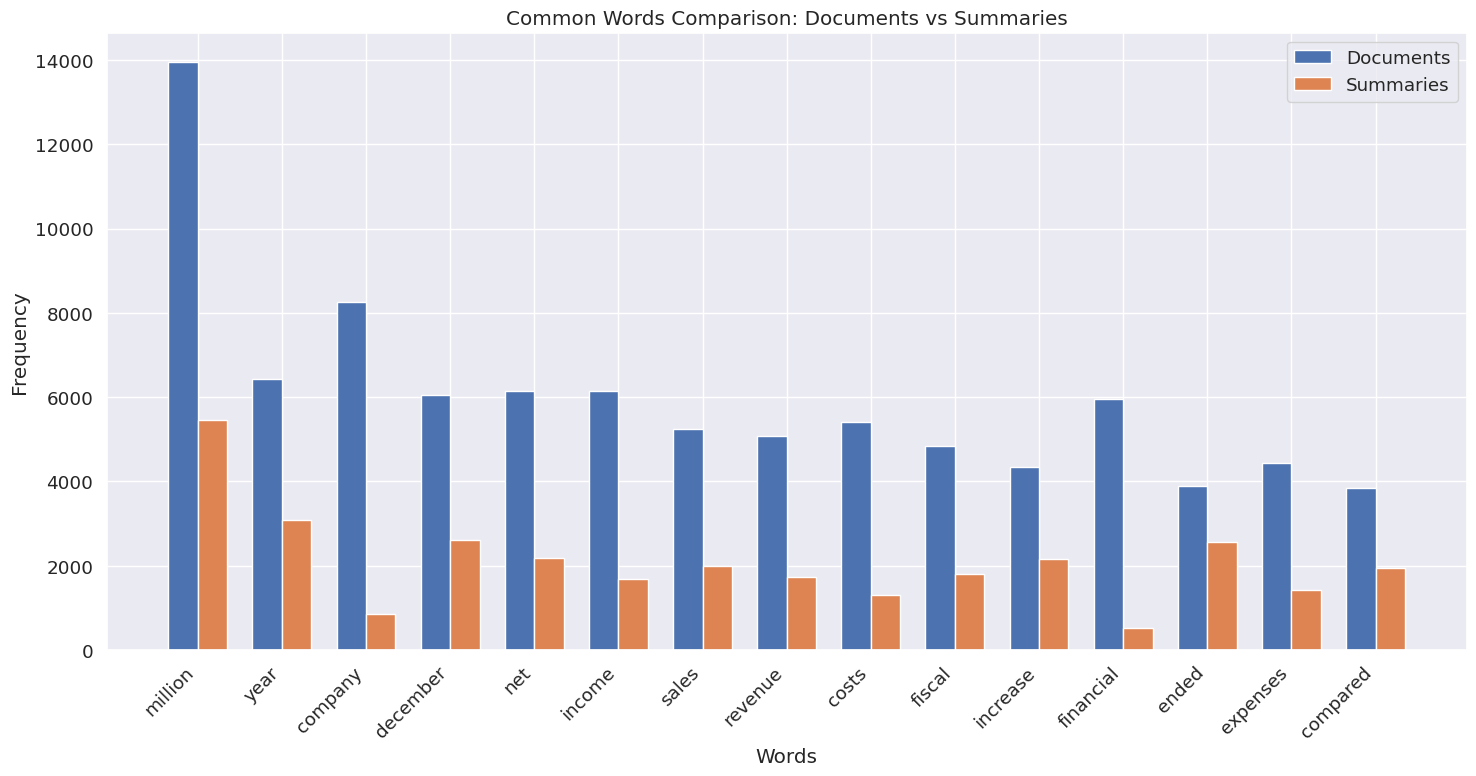


Financial entity analysis:


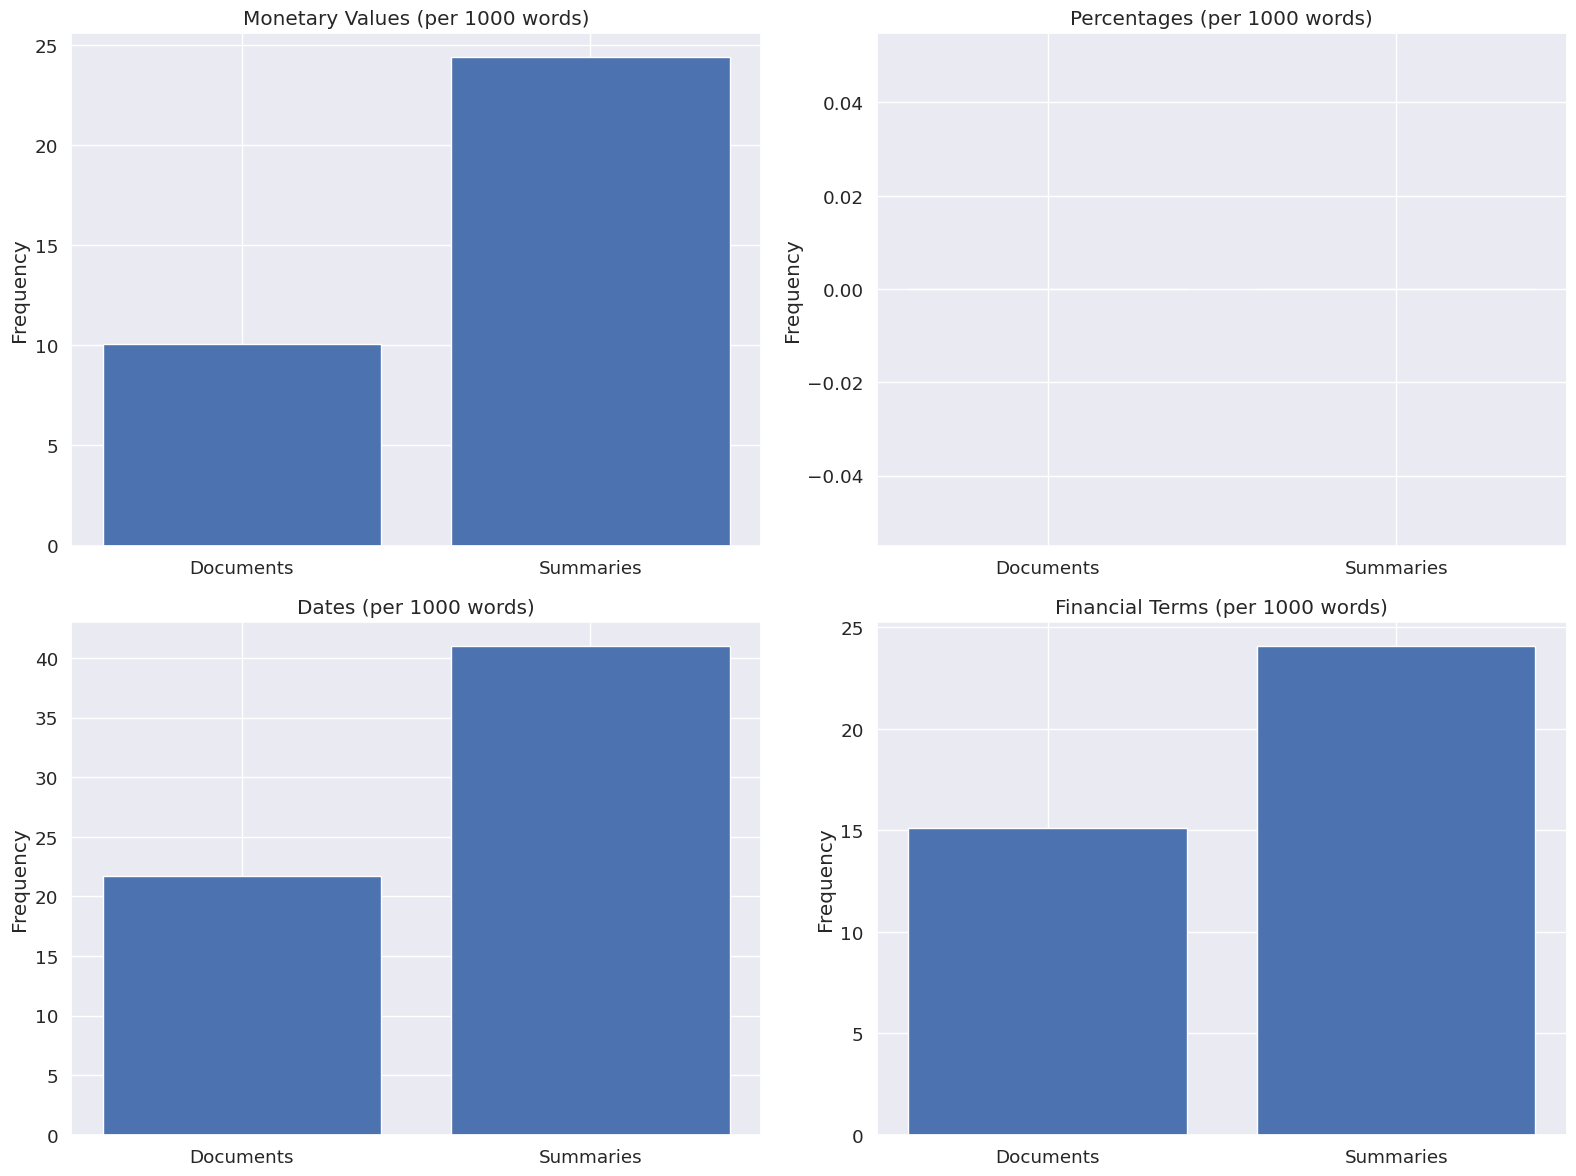

In [ ]:
def main():
    print("Loading FINDSum ROO datasets...")
    datasets = load_datasets()

    if not datasets:
        print("No datasets were loaded. Please check the folder path.")
        return

    print("\nBasic stats calculations:")
    stats = get_basic_stats(datasets)

    # Display basic statistics in a readable format
    print("\n===== Dataset Statistics =====")
    for name, stat in stats.items():
        print(f"\n--- {name} ---")
        print(f"Number of samples: {stat['count']}")
        print(f"Document lengths (words): Mean = {stat['doc_length']['mean']:.1f}, Median = {stat['doc_length']['median']:.1f}, Max = {stat['doc_length']['max']:.1f}")
        print(f"Summary lengths (words): Mean = {stat['summary_length']['mean']:.1f}, Median = {stat['summary_length']['median']:.1f}, Max = {stat['summary_length']['max']:.1f}")
        print(f"Compression ratio: Mean = {stat['compression_ratio']['mean']:.1f}, Median = {stat['compression_ratio']['median']:.1f}")
        print(f"Document sentences: Mean = {stat['doc_sentences']['mean']:.1f}, Median = {stat['doc_sentences']['median']:.1f}")
        print(f"Summary sentences: Mean = {stat['summary_sentences']['mean']:.1f}, Median = {stat['summary_sentences']['median']:.1f}")

    print("\nLength distribution:")
    visualize_length_distributions(datasets)

    print("\nVocabulary analysis:")
    analyze_vocabulary(datasets)

    print("\nFinancial entity analysis:")
    financial_entity_analysis(datasets)


if __name__ == "__main__":
    main()

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/LLM/FINDSum-ROO/roo_input_2000/test_roo_segment_0_input_2_1000.csv'
df = pd.read_csv(file_path)


In [2]:
import pandas as pd

# List of file paths
files = [
    "train_roo_segment_0_input_2_1000.csv",
    "train_roo_segment_1_input_2_1000.csv",
    "test_roo_segment_0_input_2_1000.csv",
    "test_roo_segment_1_input_2_1000.csv",
    "val_roo_segment_0_input_2_1000.csv",
    "val_roo_segment_1_input_2_1000.csv"
]

# Load and concatenate DataFrames
path = '/content/drive/MyDrive/LLM/FINDSum-ROO/roo_input_2000/'
dataframes = [pd.read_csv(path+file) for file in files]
df = pd.concat(dataframes, ignore_index=True)


In [10]:
# Display first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())


                                            document  \
0  amounts allocated to land , buildings , equipm...   
1  the risk category story_separator_special_tag ...   
2  allowances allocated to or acquired by the duk...   
3  nomination process , director candidate select...   
4  1-800-flowers.com was also rated number one vs...   

                                             summary  
0  factors impacting operating results there are ...  
1  general . loans are our primary interest-earni...  
2  results of operations replace_table_token_21_t...  
3  results of operations year ended december 31 ,...  
4  quarterly results of operations the following ...  
document    0
summary     0
dtype: int64
                                                 document  \
count                                               42048   
unique                                              41353   
top     fair value measurements – fair value is define...   
freq                                            

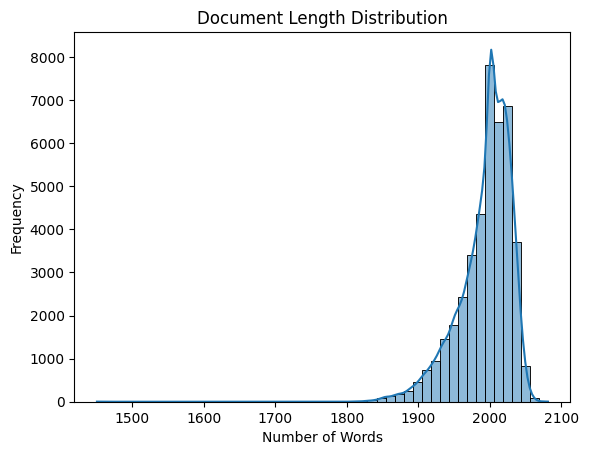

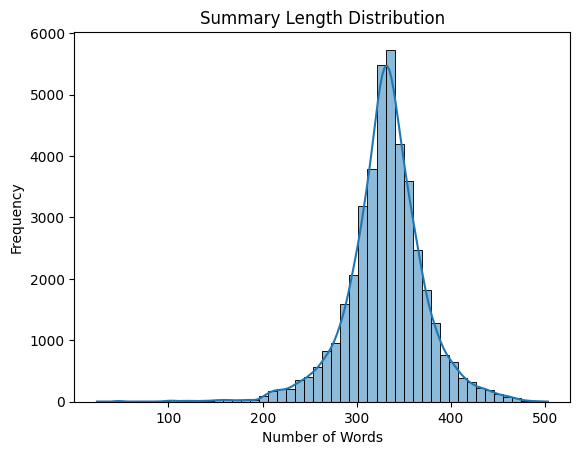

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate lengths
df['doc_length'] = df['document'].str.split().apply(len)
df['summary_length'] = df['summary'].str.split().apply(len)

# Plot distributions
sns.histplot(df['doc_length'], bins=50, kde=True)
plt.title('Document Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

sns.histplot(df['summary_length'], bins=50, kde=True)
plt.title('Summary Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [12]:
df['compression_ratio'] = df['summary_length'] / df['doc_length']
print(df['compression_ratio'].describe())


count    42048.000000
mean         0.166052
std          0.021217
min          0.011794
25%          0.155588
50%          0.166502
75%          0.177468
max          0.254317
Name: compression_ratio, dtype: float64


In [13]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess(text):
    tokens = text.lower().translate(str.maketrans('', '', string.punctuation)).split()
    return [word for word in tokens if word not in stop_words]

# Get word frequencies
doc_words = Counter()
summary_words = Counter()

for doc in df['document']:
    doc_words.update(preprocess(doc))

for summary in df['summary']:
    summary_words.update(preprocess(summary))

# Display most common words
print('Most common words in documents:', doc_words.most_common(10))
print('Most common words in summaries:', summary_words.most_common(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Most common words in documents: [('million', 628295), ('company', 318834), ('31', 294681), ('december', 289506), ('year', 271885), ('net', 267657), ('income', 259577), ('financial', 250466), ('sales', 246373), ('costs', 229967)]
Most common words in summaries: [('million', 235461), ('year', 136197), ('31', 125423), ('december', 119587), ('ended', 117640), ('increase', 92152), ('sales', 90682), ('net', 86797), ('compared', 83386), ('revenue', 78741)]


In [15]:
import pandas as pd

# File mappings
file_map = {
    "train": [
        "train_roo_segment_0_input_2_1000.csv",
        "train_roo_segment_1_input_2_1000.csv"
    ],
    "test": [
        "test_roo_segment_0_input_2_1000.csv",
        "test_roo_segment_1_input_2_1000.csv"
    ],
    "valid": [
        "val_roo_segment_0_input_2_1000.csv",
        "val_roo_segment_1_input_2_1000.csv"
    ]
}

# Load and count samples per split
split_counts = {}
split_dataframes = {}

for split, files in file_map.items():
    dfs = [pd.read_csv(path+file) for file in files]
    df = pd.concat(dfs, ignore_index=True)
    split_dataframes[split] = df
    split_counts[split] = len(df)

# Compute totals and percentages
total_samples = sum(split_counts.values())
split_percentages = {split: (count / total_samples) * 100 for split, count in split_counts.items()}

# Print metrics
print(f"Total number of samples: {total_samples}\n")
for split in split_counts:
    print(f"{split.title()} set:")
    print(f"  Number of samples: {split_counts[split]}")
    print(f"  Percentage of total: {split_percentages[split]:.2f}%\n")

# Optional: display a sample
print("Sample from training data:")
print(split_dataframes["train"].sample(1).to_string(index=False))


Total number of samples: 42048

Train set:
  Number of samples: 33640
  Percentage of total: 80.00%

Test set:
  Number of samples: 4204
  Percentage of total: 10.00%

Valid set:
  Number of samples: 4204
  Percentage of total: 10.00%

Sample from training data:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [5]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
import pandas as pd
import string
from collections import Counter

# Optional: NLTK stopwords and tokenizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


# Helper to clean and tokenize text
def tokenize(text):
    # Lowercase, remove punctuation, tokenize
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return word_tokenize(text)

# Stats containers
split_counts = {}
split_dataframes = {}
length_stats = {}
vocabularies = {}

file_map = {
    "train": [
        "train_roo_segment_0_input_2_1000.csv",
        "train_roo_segment_1_input_2_1000.csv"
    ],
    "test": [
        "test_roo_segment_0_input_2_1000.csv",
        "test_roo_segment_1_input_2_1000.csv"
    ],
    "valid": [
        "val_roo_segment_0_input_2_1000.csv",
        "val_roo_segment_1_input_2_1000.csv"
    ]
}

path = '/content/drive/MyDrive/LLM/FINDSum-ROO/roo_input_2000/'

# Load and process each split
for split, files in file_map.items():
    dfs = [pd.read_csv(path+file) for file in files]
    df = pd.concat(dfs, ignore_index=True)
    split_dataframes[split] = df
    split_counts[split] = len(df)

    # Tokenized lengths
    doc_lens = df['document'].apply(lambda x: len(tokenize(x)))
    sum_lens = df['summary'].apply(lambda x: len(tokenize(x)))

    length_stats[split] = {
        "avg_doc_len": doc_lens.mean(),
        "max_doc_len": doc_lens.max(),
        "avg_sum_len": sum_lens.mean(),
        "max_sum_len": sum_lens.max()
    }

    # Vocabulary size
    all_text = " ".join(df['document'].tolist() + df['summary'].tolist())
    tokens = tokenize(all_text)
    vocabularies[split] = len(set(tokens))

# Total and percentages
total_samples = sum(split_counts.values())
split_percentages = {split: (count / total_samples) * 100 for split, count in split_counts.items()}

# Print results
print(f"🔢 Total number of samples: {total_samples}\n")

for split in ['train', 'test', 'valid']:
    print(f"📁 {split.title()} set:")
    print(f"  - Samples: {split_counts[split]} ({split_percentages[split]:.2f}%)")
    print(f"  - Avg. doc length: {length_stats[split]['avg_doc_len']:.2f} words")
    print(f"  - Max. doc length: {length_stats[split]['max_doc_len']} words")
    print(f"  - Avg. summary length: {length_stats[split]['avg_sum_len']:.2f} words")
    print(f"  - Max. summary length: {length_stats[split]['max_sum_len']} words")
    print(f"  - Vocabulary size: {vocabularies[split]}\n")

# Sample
print("📄 Sample from training data:")
sample = split_dataframes["train"].sample(1).iloc[0]
print(f"Document (excerpt): {sample['document'][:300]}...")
print(f"Summary: {sample['summary']}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔢 Total number of samples: 42048

📁 Train set:
  - Samples: 33640 (80.00%)
  - Avg. doc length: 1776.28 words
  - Max. doc length: 1921 words
  - Avg. summary length: 289.59 words
  - Max. summary length: 444 words
  - Vocabulary size: 200548

📁 Test set:
  - Samples: 4204 (10.00%)
  - Avg. doc length: 1777.77 words
  - Max. doc length: 1896 words
  - Avg. summary length: 289.35 words
  - Max. summary length: 431 words
  - Vocabulary size: 52081

📁 Valid set:
  - Samples: 4204 (10.00%)
  - Avg. doc length: 1776.44 words
  - Max. doc length: 1887 words
  - Avg. summary length: 290.24 words
  - Max. summary length: 448 words
  - Vocabulary size: 53363

📄 Sample from training data:
Document (excerpt): we begin with an introduction to our key businesses and significant operational events in fiscal 2012. we then provide discussions of our results of operations , liquidity and capital resources , and critical accounting policies . introduction our business la-z-boy incorporated manufactures 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-c2c268817f2e>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(split_counts.keys()), y=list(split_counts.values()), palette="pastel")


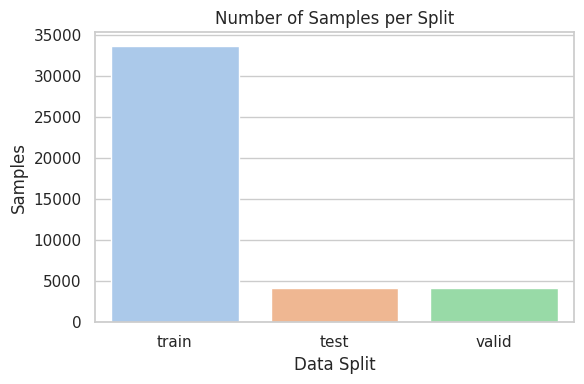

<ipython-input-3-c2c268817f2e>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=length_df, x="split", y="document_length", palette="Set2")


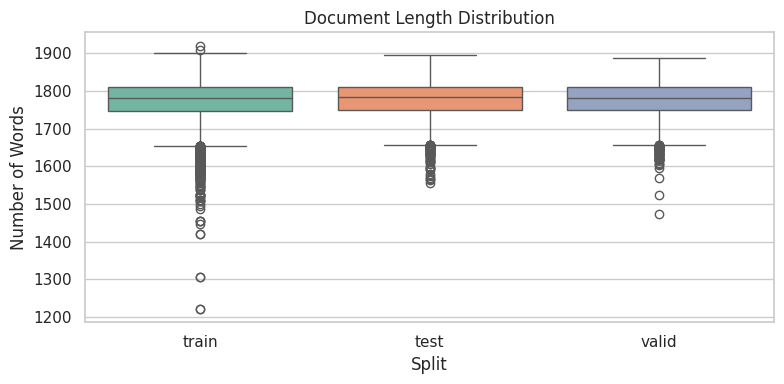

<ipython-input-3-c2c268817f2e>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=length_df, x="split", y="summary_length", palette="Set3")


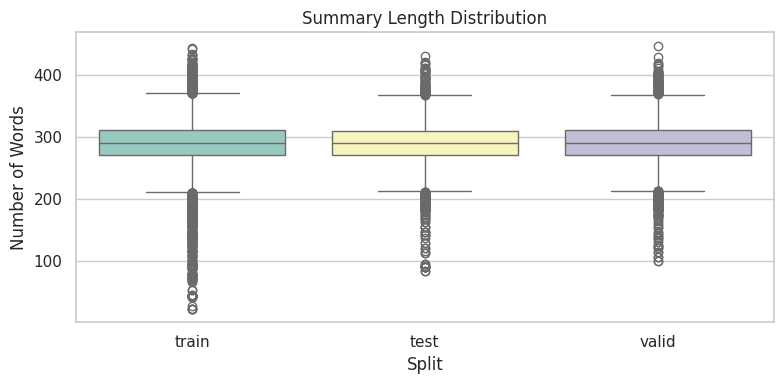

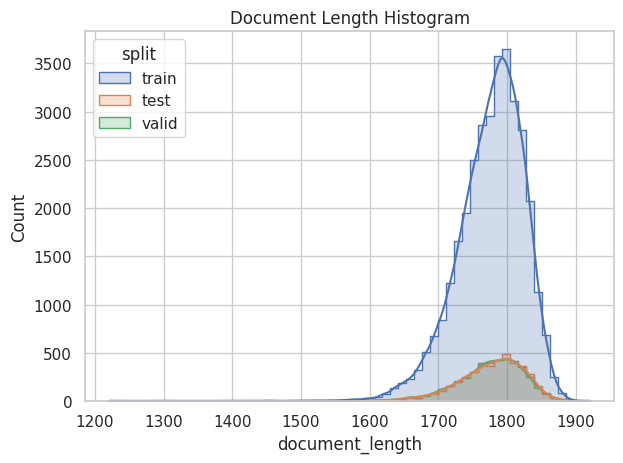

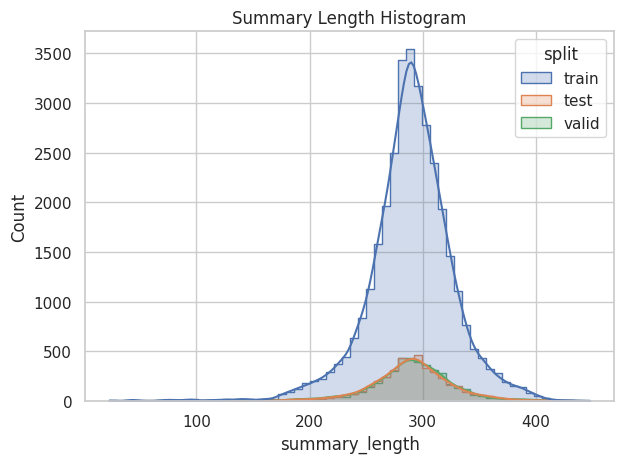

<ipython-input-3-c2c268817f2e>:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(vocabularies.keys()), y=list(vocabularies.values()), palette="muted")


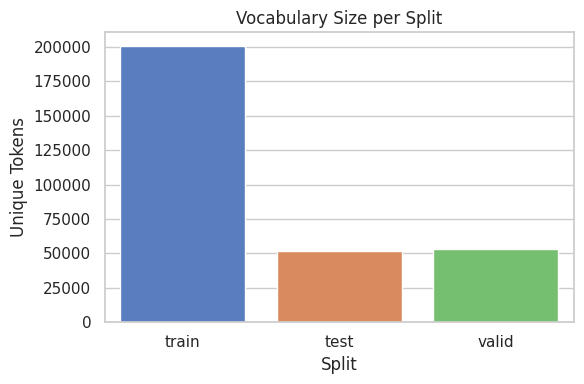

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Setup
sns.set(style="whitegrid")

file_map = {
    "train": [
        "train_roo_segment_0_input_2_1000.csv",
        "train_roo_segment_1_input_2_1000.csv"
    ],
    "test": [
        "test_roo_segment_0_input_2_1000.csv",
        "test_roo_segment_1_input_2_1000.csv"
    ],
    "valid": [
        "val_roo_segment_0_input_2_1000.csv",
        "val_roo_segment_1_input_2_1000.csv"
    ]
}

def tokenize(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return word_tokenize(text)

split_counts = {}
split_dataframes = {}
length_stats = {}
vocabularies = {}
length_data = []

# Process each split
for split, files in file_map.items():
    dfs = [pd.read_csv(path+file) for file in files]
    df = pd.concat(dfs, ignore_index=True)
    split_dataframes[split] = df
    split_counts[split] = len(df)

    doc_lens = df['document'].apply(lambda x: len(tokenize(x)))
    sum_lens = df['summary'].apply(lambda x: len(tokenize(x)))

    length_data.append(pd.DataFrame({
        'split': split,
        'document_length': doc_lens,
        'summary_length': sum_lens
    }))

    length_stats[split] = {
        "avg_doc_len": doc_lens.mean(),
        "max_doc_len": doc_lens.max(),
        "avg_sum_len": sum_lens.mean(),
        "max_sum_len": sum_lens.max()
    }

    all_text = " ".join(df['document'].tolist() + df['summary'].tolist())
    tokens = tokenize(all_text)
    vocabularies[split] = len(set(tokens))

# ============================
# 🔢 Bar Plot: Sample Counts
# ============================
plt.figure(figsize=(6, 4))
sns.barplot(x=list(split_counts.keys()), y=list(split_counts.values()), palette="pastel")
plt.title("Number of Samples per Split")
plt.ylabel("Samples")
plt.xlabel("Data Split")
plt.tight_layout()
plt.show()

# =================================
# 📦 Boxplots: Length Distributions
# =================================
length_df = pd.concat(length_data, ignore_index=True)

# Document length boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=length_df, x="split", y="document_length", palette="Set2")
plt.title("Document Length Distribution")
plt.ylabel("Number of Words")
plt.xlabel("Split")
plt.tight_layout()
plt.show()

# Summary length boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=length_df, x="split", y="summary_length", palette="Set3")
plt.title("Summary Length Distribution")
plt.ylabel("Number of Words")
plt.xlabel("Split")
plt.tight_layout()
plt.show()

# ========================================
# 📈 Histograms: Distribution of Lengths
# ========================================
g = sns.histplot(data=length_df, x="document_length", hue="split", kde=True, bins=60, element="step")
g.set_title("Document Length Histogram")
plt.tight_layout()
plt.show()

g = sns.histplot(data=length_df, x="summary_length", hue="split", kde=True, bins=60, element="step")
g.set_title("Summary Length Histogram")
plt.tight_layout()
plt.show()

# ================================
# 📊 Bar Plot: Vocabulary Sizes
# ================================
plt.figure(figsize=(6, 4))
sns.barplot(x=list(vocabularies.keys()), y=list(vocabularies.values()), palette="muted")
plt.title("Vocabulary Size per Split")
plt.ylabel("Unique Tokens")
plt.xlabel("Split")
plt.tight_layout()
plt.show()
